<a href="https://colab.research.google.com/github/jessicasalazar/vision_computador/blob/main/Taller_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop #2
1. Conduct an exploration of the dataset.
2. Extract features using a pre-trained model (ResNet-50, MobileNet, ...).
3. Train the classification head (recommended: AutoGluon).
4. Evaluate the model’s performance.

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Conduct an exploration of the dataset.

### DATASET: The LabelMe-12-50K

The dataset LabelMe-12-50k has 50,000 images: 40,000 for training, and 10,000 for testing. Each image is 256x256 pixels in size. The images are classified into one of 12 classes.

The dataset contains two types of files named annotations: The first is annotation.txt with the image file name and the class label corresponding; The second is annotation.bin which contain 12 successive 32-bit float values for each image, representing the class label of the corresponding class. Those annotation files are available to train and test.

50% of images in train and test are not classify in the 12 classes, else those are in clutter, that represent others. Furthermore, the error rate in the image classes is below.

| Method used                      | Training error rate | Testing error rate |
|----------------------------------|---------------------|--------------------|
| Locally-connected Neural Pyramid | 3.77%               | 16.27%             |


### Classes of the dataset

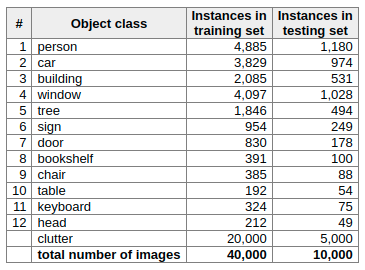

In [ ]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Doctorado/Cursos/Vision_computador_aplicado/02_Clasificacion/LabelMe_classes.png'))

In [ ]:
# Download the images in this section
!wget -qO- https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz | tar -xz -C /content/

### Environment settings

In [ ]:
# data_dir = "/content"
# split= "train"

In [ ]:
# # Define the path for dataset
# classes_txt_path = os.path.join(data_dir, "classes.txt")
# txt_path = os.path.join(data_dir, split, "annotation.txt")
# bin_path = os.path.join(data_dir, split, "annotation.bin")

# # Open data about classes
# with open(classes_txt_path, encoding="utf-8") as f:
#     classes = [x.strip() for x in f if x.strip()]
# if len(classes) != 12:
#   raise ValueError(f"Se esperaban 12 clases en '{classes_txt_path}', hay {len(classes)}.")
# else:
#   print(f"Las categorías totales son: {len(classes)}")

# # Create the extra class, It is "clutter" and represent the 50% of the images
# classes_plus = classes + ["clutter"]

# # Read the file named "annotation.txt" to create the name of image and link with the label correspondig to the class
# df_txt = pd.read_csv(txt_path, sep=r"\s+", header=None, dtype={0: str}, engine="python")
# df_txt

# # Verify the IDs column in annotation.txt
# if df_txt.shape[1] < 1:
#     raise ValueError(f"'{txt_path}' no tiene columna de IDs.")
# ids = df_txt.iloc[:, 0].to_numpy()

# # Create the route for each image in this project
# images = [os.path.join(data_dir, split, '0'+i[0:3], i[-6:]+'.jpg') for i in ids]

# # Read the bin file
# raw = np.fromfile(bin_path, dtype=np.float32)

# # Verify the size of the matrix, should be 12
# if raw.size % 12 != 0:
#     raise ValueError(f"El binario '{bin_path}' no tiene múltiplo de 12 columnas (size={raw.size}).")

# # Reshape from vector to matrix
# scores = raw.reshape(-1, 12)

# # Clasify each image within the corresponding class
# is_one = np.isclose(scores, 1.0, atol=1e-6)
# has_obj = is_one.any(axis=1)
# first_one = is_one.argmax(axis=1)          # índice de la primera columna == 1.0
# int_label = np.where(has_obj, first_one, 12)
# str_label = [classes_plus[i] for i in int_label]

In [ ]:
def load_split_from_bin_with_classes(data_dir, split, atol=1e-6):

  # Define the path for dataset
  classes_txt_path = os.path.join(data_dir, "classes.txt")
  txt_path = os.path.join(data_dir, split, "annotation.txt")
  bin_path = os.path.join(data_dir, split, "annotation.bin")

  # Open data about classes
  with open(classes_txt_path, encoding="utf-8") as f:
      classes = [x.strip() for x in f if x.strip()]
  if len(classes) != 12:
    raise ValueError(f"Se esperaban 12 clases en '{classes_txt_path}', hay {len(classes)}.")
  else:
    print(f"Las categorías totales son: {len(classes)}")

  # Create the extra class, It is "clutter" and represent the 50% of the images
  classes_plus = classes + ["clutter"]

  # Read the file named "annotation.txt" to create the name of image and link with the label correspondig to the class
  df_txt = pd.read_csv(txt_path, sep=r"\s+", header=None, dtype={0: str}, engine="python")
  df_txt

  # Verify the IDs column in annotation.txt
  if df_txt.shape[1] < 1:
      raise ValueError(f"'{txt_path}' no tiene columna de IDs.")
  ids = df_txt.iloc[:, 0].to_numpy()

  # Create the route for each image in this project
  images = [os.path.join(data_dir, split, '0'+i[0:3], i[-6:]+'.jpg') for i in ids]

  # Read the bin file
  raw = np.fromfile(bin_path, dtype=np.float32)

  # Verify the size of the matrix, should be 12
  if raw.size % 12 != 0:
      raise ValueError(f"El binario '{bin_path}' no tiene múltiplo de 12 columnas (size={raw.size}).")

  # Reshape from vector to matrix
  scores = raw.reshape(-1, 12)

  # Clasify each image within the corresponding class
  is_one = np.isclose(scores, 1.0, atol=atol)
  has_obj = is_one.any(axis=1)
  first_one = is_one.argmax(axis=1)          # índice de la primera columna == 1.0
  int_label = np.where(has_obj, first_one, 12)
  str_label = [classes_plus[i] for i in int_label]

  # Create the final dataset
  df = pd.DataFrame({
      "image": images,
      "label": int_label
      })
  return df

In [ ]:
DATA_DIR = "/content"  # ajusta a tu ruta
train_df= load_split_from_bin_with_classes(DATA_DIR, "train")
test_df = load_split_from_bin_with_classes(DATA_DIR, "test")

# construir categorias
train_df.label = train_df.label.astype("category")
test_df.label = test_df.label.astype("category")

Las categorías totales son: 12
Las categorías totales son: 12


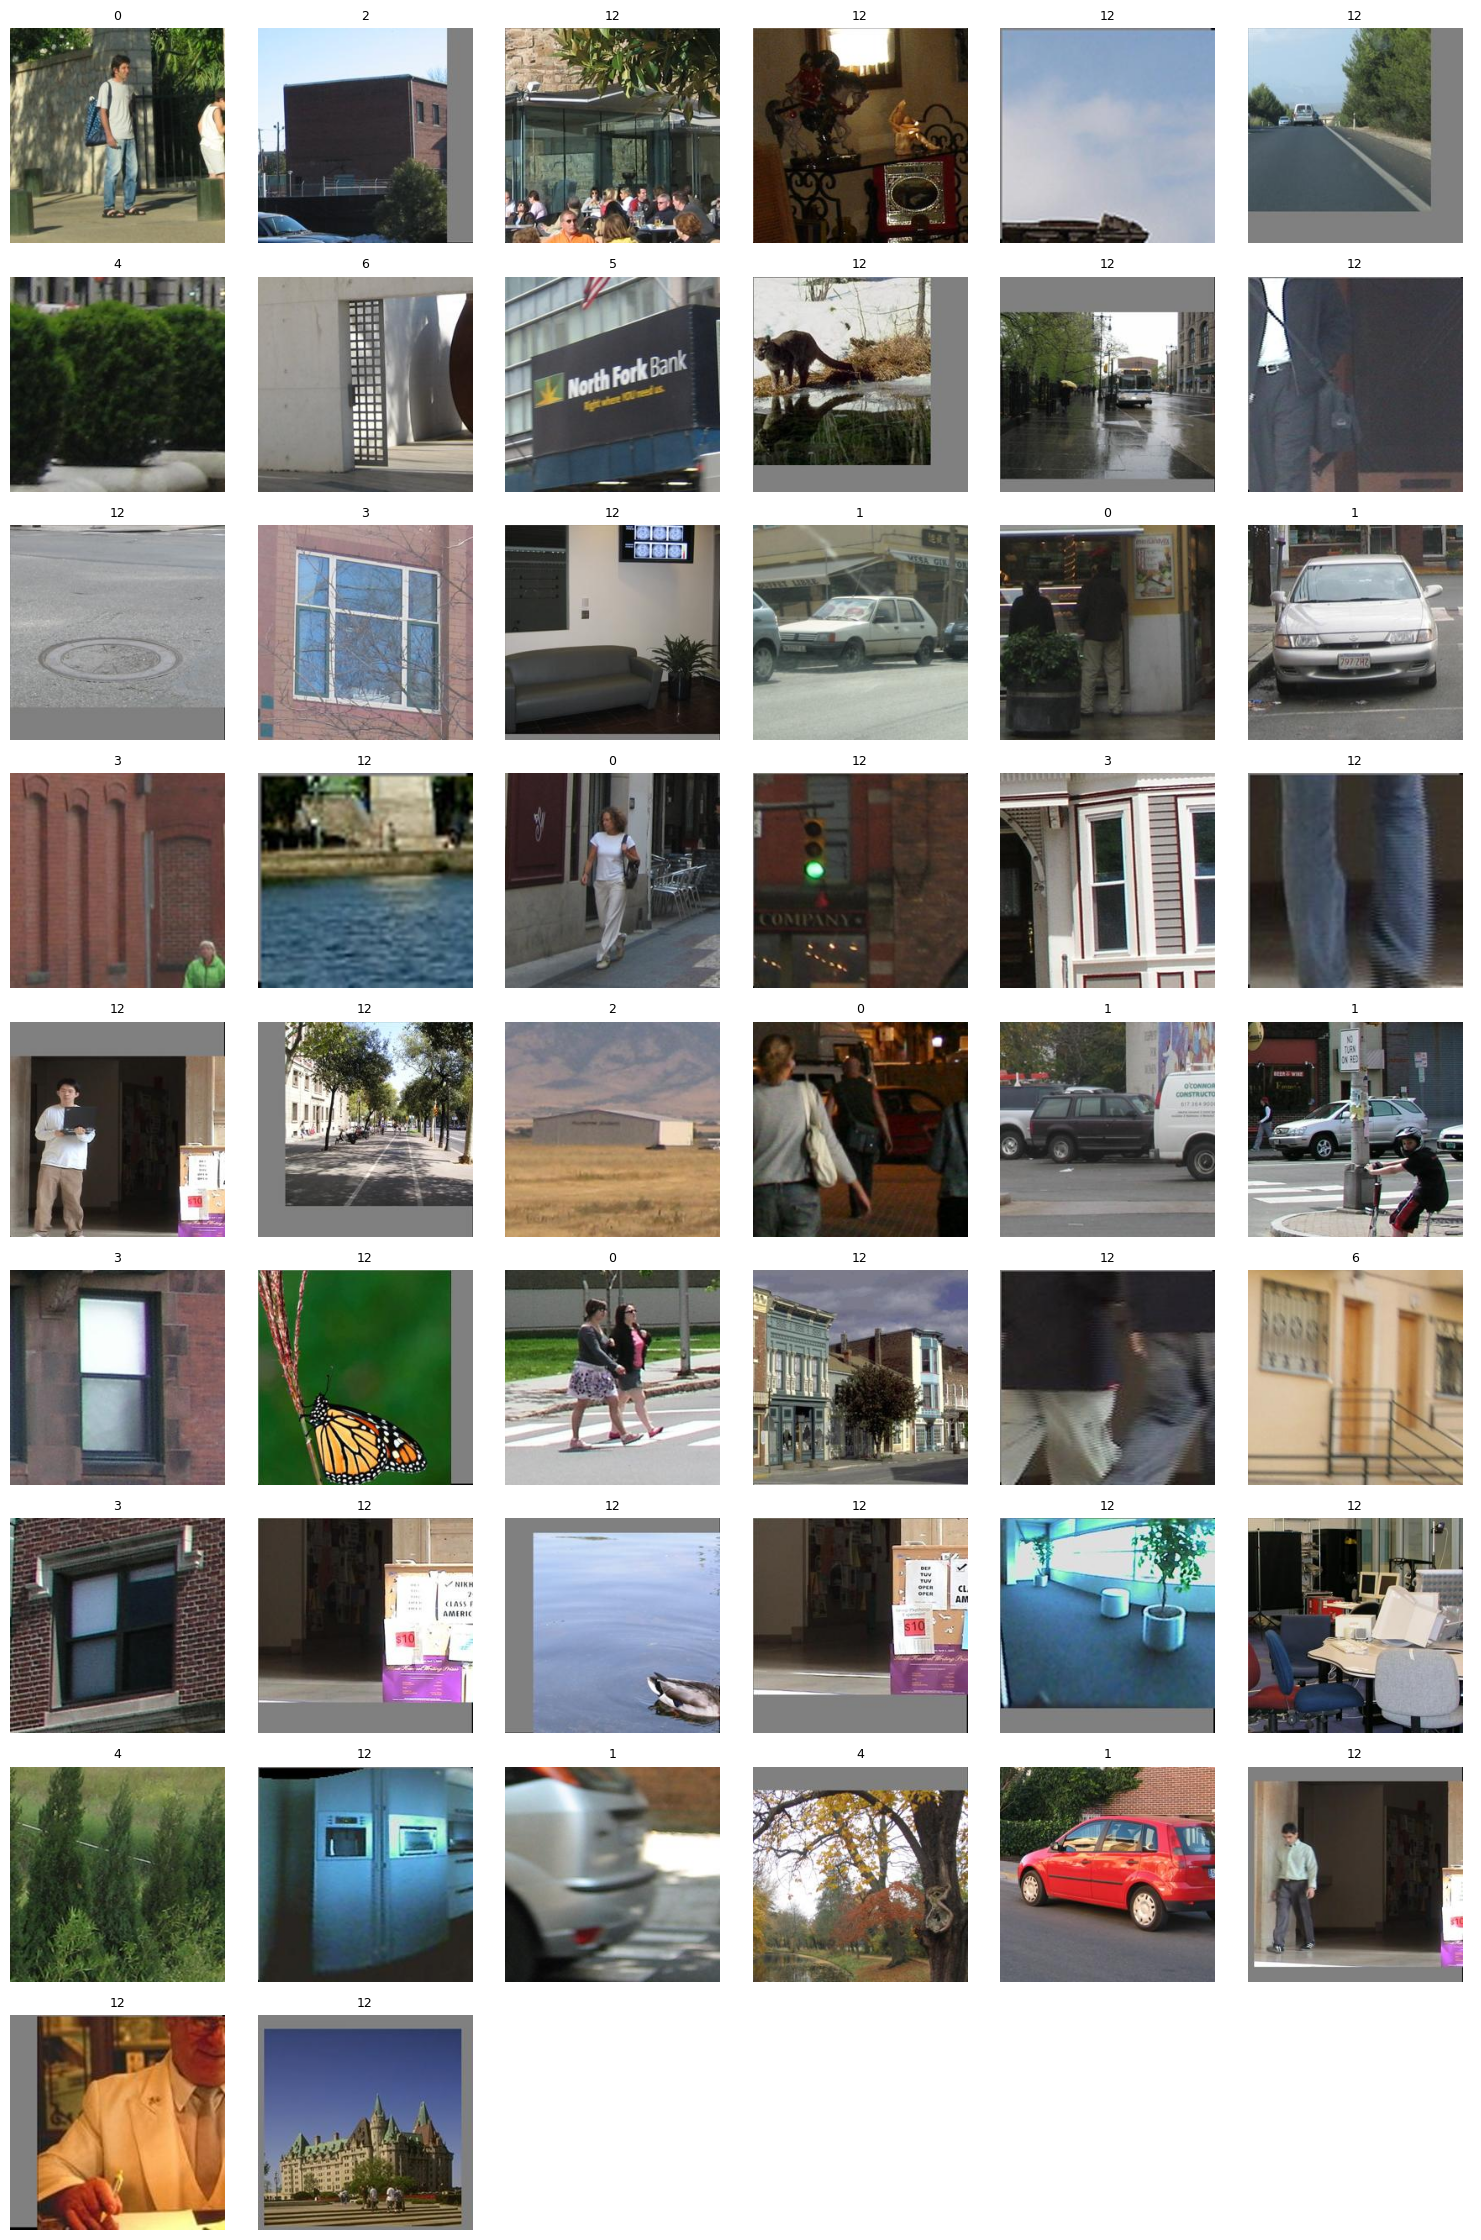

In [ ]:
import math
import matplotlib.pyplot as plt

def ver_grid(df, n=12, cols=4):
    """
    Muestra un grid simple de imágenes con su etiqueta.
    Requiere columnas: 'img_path' y 'str_label' en df.
    """
    sel = df.sample(n=min(n, len(df))).reset_index(drop=True)
    rows = math.ceil(len(sel) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
    axes = axes.ravel() if rows*cols > 1 else [axes]

    for i, row in sel.iterrows():
        ax = axes[i]
        ax.imshow(plt.imread(row["image"]))
        ax.set_title(str(row["label"]), fontsize=9)
        ax.axis("off")

    # Oculta ejes sobrantes si no se llenó el grid
    for j in range(len(sel), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

ver_grid(train_df, 50, 6)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

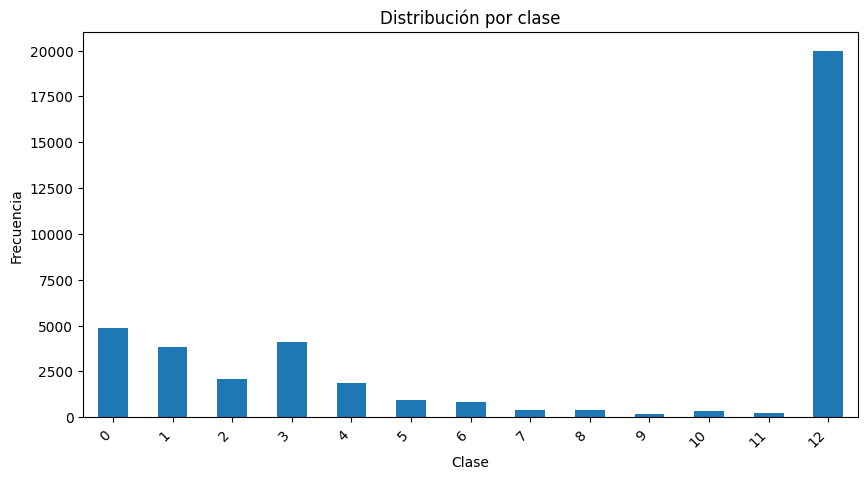

In [ ]:
counts = train_df["label"].value_counts().sort_index()
fig = plt.figure(figsize=(10, 5))
counts.plot(kind="bar")
plt.title("Distribución por clase")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")

# 2. Extract features using a pre-trained model (ResNet-50, MobileNet, ...).

# 3. Train the classification head (recommended: AutoGluon).

In [ ]:
! pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━

In [ ]:
# Celda 5 — split estratificado 70/15/15
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_df, test_size=0.20, stratify=train_df["label"], random_state=42)


In [ ]:
from autogluon.multimodal import MultiModalPredictor

In [ ]:
predictor = MultiModalPredictor(problem_type="multiclass", label='label')

In [ ]:
hparams = {
    "model.names" : ["timm_image"],
    "model.timm_image.checkpoint_name": "resnet50",
    "optim.lr_choice": "two_stages",
    "optim.lr_mult": 50,
    "optim.lr": 1e-4,
    "optim.max_epochs": 5,
    "optim.patience": 5
}

In [ ]:
predictor.fit(
    hyperparameters = hparams,
    presets = "medium_quality",
    train_data = df_train,
    tuning_data = df_val
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251007_164355"
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Sep  6 09:54:41 UTC 2025
CPU Count:          2
Pytorch Version:    2.6.0+cu124
CUDA Version:       12.4
GPU Count:          1
Memory Avail:       8.19 GB / 12.67 GB (64.6%)
Disk Space Avail:   26.22 GB / 73.59 GB (35.6%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/AutogluonModels/ag-20251007_164355
    ```

INFO: Seed set to 0
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your 

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 23.5 M | train
1 | validation_metric | MulticlassAccuracy              | 0      | train
2 | loss_func         | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------------------
23.5 M    Trainable params
0         N

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 125: 'val_accuracy' reached 0.76800 (best 0.76800), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=0-step=125.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 250: 'val_accuracy' reached 0.84475 (best 0.84475), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=0-step=250.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 375: 'val_accuracy' reached 0.88437 (best 0.88437), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=1-step=375.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 500: 'val_accuracy' reached 0.90700 (best 0.90700), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=1-step=500.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 625: 'val_accuracy' reached 0.91612 (best 0.91612), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=2-step=625.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 750: 'val_accuracy' reached 0.92488 (best 0.92488), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=2-step=750.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 875: 'val_accuracy' reached 0.93012 (best 0.93012), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=3-step=875.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1000: 'val_accuracy' reached 0.93063 (best 0.93063), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=3-step=1000.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1125: 'val_accuracy' reached 0.93362 (best 0.93362), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=4-step=1125.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1250: 'val_accuracy' reached 0.93463 (best 0.93463), saving model to '/content/AutogluonModels/ag-20251007_164355/epoch=4-step=1250.ckpt' as top 3
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/AutogluonModels/ag-20251007_164355")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [ ]:
predictor.evaluate(df_val)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

{'accuracy': 0.93475}

In [ ]:
predictor.evaluate(test_df)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

{'accuracy': 0.931}

In [ ]:
# Mirar cómo se ejecuta el tensorboard
# ! tensorboard --logdir /content/AutogluonModels/ag-20251005_002855